![TrustKeeper](img/TK_logo.png)

![TrustKeeperHowItWorks](img/TK_how.png)

# Description

#### In this notebook, we show how to implement TrustKeeper algorithm to predict fraudulent transactions in the context of a Peer-to-Peer (P2P) Bitcoin transaction network

#### We will first compute node embeddings using the Node2Vec algorithm and the information from the adjacency matrix in the Bitcoin network. Finally, we will use these node representations to train different classifiers for predicting transaction scores.

### Import basic libraries

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn import manifold
%matplotlib inline

# **Part 1 - Preprocessing Transaction Rating Data**

# How do people rate each other on Bitcoin Marketplaces?

![TrustKeeperScore](img/TK_rating.png)

#### Load TRIMMED_NETWORK for extracting the node data that will be used to train models. Let's look at a portion of the table

In [178]:
trim_network = pd.read_csv('2_TRIMMED_NETWORK.csv')
trim_network.head(20)

,SOURCE,TARGET,RATING,TIMESTAMP,EPISODE
0,35,3952,1,1.365623e+09,21958
1,2125,5379,-1,1.392045e+09,32086
2,5227,5854,1,1.417038e+09,35751
3,6013,13492,-1,1.393304e+09,32395
4,6013,13495,-1,1.392008e+09,32075
5,6286,7603,3,1.424581e+09,36282
6,6287,6729,10,1.307678e+09,4623
7,6,2,4,1.289242e+09,1
8,6,5,2,1.289242e+09,2
9,1,15,1,1.289243e+09,3


#### Define function to extract node features from the network dataframe

In [5]:
def GetNodeFeatures(GDF,n):
    if n==0:
        return ['in_degree','pos_in_edges','neg_in_edges','out_degree','pos_out_edges','neg_out_edges']
    # Get sub-dataframes
    outgoing = GDF[GDF['SOURCE']==n].copy().reset_index(drop=True)
    incoming = GDF[GDF['TARGET']==n].copy().reset_index(drop=True)
    
    # Compute node degree (incoming)
    in_degree = len(incoming)
    
    # Compute node degree (outgoing)
    out_degree = len(outgoing)
    
    # Compute number of incoming nodes with positive ratings
    pos_in_edges = len([i for i in incoming.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings
    neg_in_edges = len([i for i in incoming.RATING.values if i<0])
    
    # Repeat for outgoing edges
    pos_out_edges = len([i for i in outgoing.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings
    neg_out_edges = len([i for i in outgoing.RATING.values if i<0])
    
    return np.array([in_degree,pos_in_edges,neg_in_edges,out_degree,pos_out_edges,neg_out_edges])

#### Obtain node features for all nodes in trimmed network

In [6]:
# Define list of nodes and sort it in ascending order
nodes = list( set(trim_network['SOURCE']) | set(trim_network['TARGET']) )
nodes.sort()

# Create NF, the node feature matrix
NF = np.zeros([len(nodes),6])
for i,n in enumerate(nodes):
    NF[i,:] = np.array(GetNodeFeatures(trim_network,n))
    
# Create a dataframe containing all these node features
NF_df = pd.DataFrame(columns=GetNodeFeatures(trim_network,0),data=NF,index=nodes)
NF_df.to_csv('trimmed_node_features.csv')

#### Create an edgelist file for the trimmed network

In [7]:
f = open('trimmed_network.edgelist','w')
for i in range(len(trim_network)):
    s = str(trim_network['SOURCE'][i])
    t = str(trim_network['TARGET'][i])
    f.write(s+' '+t+'\n')
f.close()

#### Run [Node2Vec](https://snap.stanford.edu/node2vec/) to learn an embedding for each node in the trimmed_network

We will set the embedding dimension to 14, the number of walks to 25, and the number of iterations to 15.

Run this command in your terminal inside this directory (make sure your python environment is set to python=2.7). This step will take a while
```bash
python ./node2vec/src/main.py --input ./trimmed_network.edgelist --output ./trimmed_network.emb --dimensions 14 --num-walks 25 --iter 15
```

#### Create dictionary of nodes:embeddings fromthe trimmed_network.emb file created above

In [61]:
n = []
e = []
with open('./trimmed_network.emb') as fin:
    for line in fin:
        node_emb = line.strip().split()
        n.append(node_emb[0])
        e.append(node_emb[1:])
n = n[1:]
n = [int(i) for i in n]
embs = np.zeros([len(e)-1,14])
for i in range(1,len(e)):
    embs[i-1] = e[i]
embs.shape

(9664, 14)

#### Create a 2D projection of the embeddings using [t-SNE](https://lvdmaaten.github.io/tsne/)

In [34]:
#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#proj = tsne.fit_transform(embs)
#np.save('trimmed_network_tSNE_projection.npy',proj)
proj = np.load('trimmed_network_tSNE_projection.npy')

#### Plot node projections and color them according to the Bitcoin Marketplace they belong to (OTC or ALPHA)

In [62]:
alpha_nodes = []
otc_nodes = []
for i in range(len(n)):
    if n[i] > 6005: # The highest OTC node ID is 6005
        alpha_nodes.append(i)
    else:
        otc_nodes.append(i)

Text(0.5,1,'2-dimensional mapping with t-SNE of Bitcoin network nodes with Node2Vec')

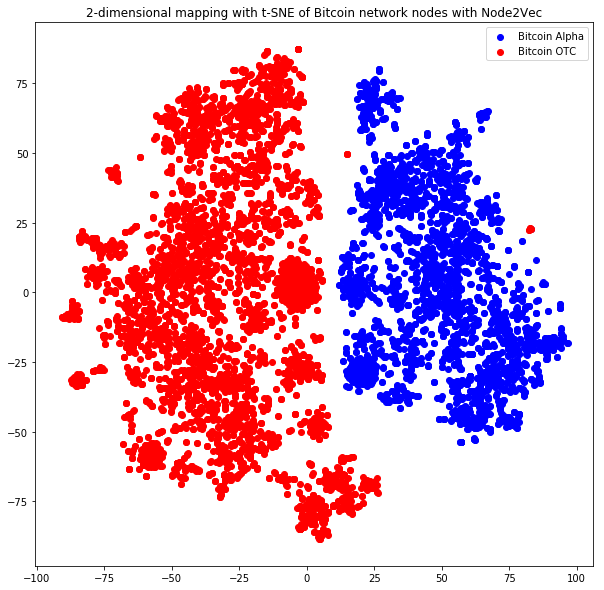

In [63]:
plt.figure(figsize=(10,10))
alpha = proj[alpha_nodes,:]
otc = proj[otc_nodes,:]
plt.scatter(alpha[:,0],alpha[:,1],c='b',label='Bitcoin Alpha')
plt.scatter(otc[:,0],otc[:,1],c='r',label='Bitcoin OTC')
plt.legend()
plt.title('2-dimensional mapping with t-SNE of Bitcoin network nodes with Node2Vec')

#### Thus, for the most part, Node2Vec is able to represent nodes in a 14-dimensional space that accounts for the network structure the nodes' neighborhoods. We will expand these node representations by concatenating the 6 node features we calculated earlier so that we get a final 20-dimensional representation for each node.

#### Concatenate Node2Vec embeddings with node features

In [71]:
NF_matrix = np.zeros([len(n),20]) # Recall that we have 14 Node2Vec features plus 6 features extracted from the rating network
for i in range(len(n)):
    NF_matrix[i] = np.concatenate([embs[i],NF_df.loc[n[i]].values])
NF_matrix.shape

(9664, 20)

#### Because all 20 features have different scales, we will normalize the entire matrix using the following formula:

$$X_{normalized}=\frac{X - X_{min}}{X_{max}-X_{min}}$$

Where $X_{min/max}$ is the columnwise minimum/maximum value of the matrix $X$. In this way, we ensure that all values in the matrix lie within the [0,1] range

In [75]:
NF_matrix_min = np.min(NF_matrix,axis=0)
NF_matrix_max = np.max(NF_matrix,axis=0)
NF_matrix_norm = ( NF_matrix - NF_matrix_min ) / ( NF_matrix_max - NF_matrix_min )

#### Capture node ID and embedding into a DataFrame

In [78]:
emb_df_norm = pd.DataFrame(columns=list(range(1,21)),index=n,data=NF_matrix_norm)
emb_df_norm.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
35,0.167553,0.444406,0.472663,0.506634,0.576703,0.429334,0.372962,0.620359,0.547468,0.710448,0.226748,0.463918,0.295785,0.475912,1.000000,1.000000,0.000000,1.000000,1.000000,0.047619
6006,0.340063,0.479300,0.561667,0.213713,0.427346,0.760799,0.438482,0.653109,0.594130,0.366386,0.338275,0.427905,0.242330,0.578119,0.740899,0.740899,0.000000,0.619327,0.625557,0.009524
2642,0.253638,0.438191,0.613761,0.426420,0.486094,0.538448,0.411753,0.749950,0.660550,0.791435,0.286897,0.566561,0.327908,0.434380,0.710921,0.708779,0.016667,0.515373,0.512630,0.033333
2125,0.430843,0.571506,0.398806,0.386505,0.468770,0.407351,0.339845,0.783298,0.673810,0.734899,0.248113,0.663124,0.461399,0.441425,0.323340,0.323340,0.000000,0.515373,0.210996,1.000000
1810,0.417830,0.525865,0.509467,0.390729,0.615571,0.442351,0.365146,0.909299,0.590005,0.669036,0.299592,0.569811,0.395410,0.481177,0.571734,0.494647,0.600000,0.500732,0.310550,0.633333


#### Construct the input matrix $X$ and the output vector $y$. Each row of the $X$ matrix contains 40 values (20 values for the source node or buyer, 20 values for the target node or seller). The $y$ vector captures the rating of the transaction the seller received from the buyer. 

#### **NOTE:** Here we assign a score of 1 if transaction is rated badly (fraud), and 0 otherwise

In [82]:
X = np.zeros([len(trim_network),40])
y = np.zeros(len(trim_network))
for i in range(len(trim_network)):
    s = trim_network['SOURCE'][i]
    t = trim_network['TARGET'][i]
    r = trim_network['RATING'][i]
    left = emb_df_norm.loc[s,:].values
    right = emb_df_norm.loc[t,:].values
    X[i,:] = np.concatenate([left,right])
    if r>0:
        y[i] = 0 # If not fraud
    else:
        y[i] = 1 # If fraud

#### Repeat procedure for calculating the $X_{val}$ and $y_{val}$ from the validation table

In [85]:
val_network = pd.read_csv('3_TEST_NETWORK.csv')
X_val = np.zeros([len(val_network),40])
y_val = np.zeros(len(val_network))
for i in range(len(val_network)):
    s = val_network['SOURCE'][i]
    t = val_network['TARGET'][i]
    r = val_network['RATING'][i]
    left = emb_df_norm.loc[s,:].values
    right = emb_df_norm.loc[t,:].values
    X_val[i,:] = np.concatenate([left,right])
    if r>0:
        y_val[i] = 0 # If not fraud
    else:
        y_val[i] = 1 # If fraud (class imbalance)

# **Part 2 - Model Construction, training, and evaluation**

#### Models evaluated:

* Deep Neural Network (trained with binary crossentropy loss function)
* Deep Neural Network (trained with focal loss function)
* Logistic Regression

#### Load Machine/Deep Learning libraries

In [88]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers.merge import Concatenate

Using TensorFlow backend.
/Users/jahirgutierrez/miniconda2/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Define function for generating small samples from training data to train Neural Networks without biasing it towards the most abundant category (0)

In [89]:
# Create train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=0)
def CreateSample(frac=0.8):
    fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==1])
    not_fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==0])
    sample_size = int(np.round( len(fraud_indices) * frac ))
    fraud_sample = np.random.randint(0,len(fraud_indices),sample_size) 
    not_fraud_sample = np.random.randint(0,len(not_fraud_indices),sample_size)
    y_sample = np.concatenate([y_train[fraud_indices][fraud_sample],y_train[not_fraud_indices[not_fraud_sample]]])
    x_sample = np.concatenate([x_train[fraud_indices][fraud_sample],x_train[not_fraud_indices[not_fraud_sample]]])
    return x_sample,y_sample

#### Define Focal Loss Function

In [90]:
from keras import backend as K
import tensorflow as tf
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

### Construct Model 1 (Neural Network with binary crossentropy)

In [109]:
# Initialize model

input_size = 40 # Features from X matrix

M1 = Sequential()

# Add an input layer
M1.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1.add(Dense(128, activation='relu'))

# Add second hidden layer
M1.add(Dense(64, activation='relu'))

#Add third hidden layer
M1.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1.add(Dense(16, activation='relu'))

# Add output layer
M1.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M1.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

### Train Model 1

In [110]:
for i in range(10):
    sample_x,sample_y = CreateSample()
    M1.fit(sample_x, sample_y, epochs=Nepochs, batch_size=5, verbose=0)

### Evaluate Model 1 with test set

In [93]:
y_pred = M1.predict(x_test)
# Print confusion matrix
confusion_matrix = cm(y_test, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_test, np.round(y_pred)))

[[7941 1178]
 [ 229  617]]
             precision    recall  f1-score   support

        0.0       0.97      0.87      0.92      9119
        1.0       0.34      0.73      0.47       846

avg / total       0.92      0.86      0.88      9965



### Evaluate Model 1 with validation set

In [94]:
y_pred = M1.predict(X_val)
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_val, np.round(y_pred)))

[[7771 1304]
 [ 268  613]]
             precision    recall  f1-score   support

        0.0       0.97      0.86      0.91      9075
        1.0       0.32      0.70      0.44       881

avg / total       0.91      0.84      0.87      9956



### Construct Model 2 (Neural Network with Focal Loss)

In [95]:
# Initialize model

input_size = 40

M2 = Sequential()

# Add an input layer
M2.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M2.add(Dense(128, activation='relu'))

# Add second hidden layer
M2.add(Dense(64, activation='relu'))

#Add third hidden layer
M2.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M2.add(Dense(16, activation='relu'))

# Add output layer
M2.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M2.compile(loss=[focal_loss(alpha=.25, gamma=5)],
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

### Train Model 2

In [96]:
# Initialize FOR loop
for i in range(10):
    sample_x,sample_y = CreateSample()
    M2.fit(sample_x, sample_y, epochs=Nepochs, batch_size=5, verbose=0)

### Evaluate Model 2 with test data

In [97]:
y_pred = M2.predict(x_test)
# Print confusion matrix
confusion_matrix = cm(y_test, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_test, np.round(y_pred)))

[[8723  396]
 [ 400  446]]
             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96      9119
        1.0       0.53      0.53      0.53       846

avg / total       0.92      0.92      0.92      9965



### Evaluate Model 3 with validation data

In [98]:
y_pred = M2.predict(X_val)
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_val, np.round(y_pred)))

[[8640  435]
 [ 442  439]]
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95      9075
        1.0       0.50      0.50      0.50       881

avg / total       0.91      0.91      0.91      9956



### Construct Model 3 (Logistic Regression)

In [99]:
M3 = LogisticRegression()

### Train Model 3

In [100]:
M3.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Evaluate Model 3 with test data

In [101]:
y_pred = M3.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M3.score(x_test, y_test)))

confusion_matrix = cm(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.93
[[9007  112]
 [ 631  215]]
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96      9119
        1.0       0.66      0.25      0.37       846

avg / total       0.91      0.93      0.91      9965



### Evaluate Model 3 with validation data

In [102]:
y_pred = M3.predict(X_val)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M3.score(X_val, y_val)))

confusion_matrix = cm(y_val, y_pred)
print(confusion_matrix)
print(classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on test set: 0.92
[[8959  116]
 [ 654  227]]
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96      9075
        1.0       0.66      0.26      0.37       881

avg / total       0.91      0.92      0.91      9956



# Part 3 - Model evaluation when Node2Vec features are removed

### Model 1B (Neural Network trained with Binary Crossentropy with node features only)

In [111]:
# Initialize model

input_size = 12 # Node features only

M1B = Sequential()

# Add an input layer
M1B.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1B.add(Dense(128, activation='relu'))

# Add second hidden layer
M1B.add(Dense(64, activation='relu'))

#Add third hidden layer
M1B.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1B.add(Dense(16, activation='relu'))

# Add output layer
M1B.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M1B.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

12


In [ ]:
# Define list of columns to consider from X matrix
f = list(range(14,20)) + list(range(34,40))
print(len(f))

In [112]:
# Train
for i in range(10):
    sample_x,sample_y = CreateSample()
    M1B.fit(sample_x[:,f], sample_y, epochs=Nepochs, batch_size=5, verbose=0)

In [113]:
# Evaluate with test data
y_pred = M1B.predict(x_test[:,f])
# Print confusion matrix
confusion_matrix = cm(y_test, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_test, np.round(y_pred)))

[[7968 1151]
 [ 163  683]]
             precision    recall  f1-score   support

        0.0       0.98      0.87      0.92      9119
        1.0       0.37      0.81      0.51       846

avg / total       0.93      0.87      0.89      9965



In [114]:
# Evaluate with validation data
y_pred = M1B.predict(X_val[:,f])
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_val, np.round(y_pred)))

[[7739 1336]
 [ 220  661]]
             precision    recall  f1-score   support

        0.0       0.97      0.85      0.91      9075
        1.0       0.33      0.75      0.46       881

avg / total       0.92      0.84      0.87      9956



### Model 2B (Neural Network with Focal Loss with node features only)

In [115]:
# Initialize model

input_size = 12

M2B = Sequential()

# Add an input layer
M2B.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M2B.add(Dense(128, activation='relu'))

# Add second hidden layer
M2B.add(Dense(64, activation='relu'))

#Add third hidden layer
M2B.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M2B.add(Dense(16, activation='relu'))

# Add output layer
M2B.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M2B.compile(loss=[focal_loss(alpha=.25, gamma=5)],
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

In [116]:
# Train
for i in range(10):
    sample_x,sample_y = CreateSample()
    M2B.fit(sample_x[:,f], sample_y, epochs=Nepochs, batch_size=5, verbose=0)

In [117]:
# Evaluate with test data
y_pred = M2B.predict(x_test[:,f])
# Print confusion matrix
confusion_matrix = cm(y_test, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_test, np.round(y_pred)))

[[8617  502]
 [ 316  530]]
             precision    recall  f1-score   support

        0.0       0.96      0.94      0.95      9119
        1.0       0.51      0.63      0.56       846

avg / total       0.93      0.92      0.92      9965



In [118]:
# Evaluate with validation data
y_pred = M2B.predict(X_val[:,f])
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print(confusion_matrix)
print(classification_report(y_val, np.round(y_pred)))

[[8496  579]
 [ 352  529]]
             precision    recall  f1-score   support

        0.0       0.96      0.94      0.95      9075
        1.0       0.48      0.60      0.53       881

avg / total       0.92      0.91      0.91      9956



### Model 3 (Logistic Regression with node features only)

In [119]:
M3B = LogisticRegression()
M3B.fit(x_train[:,f], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
y_pred = M3B.predict(x_test[:,f])
print('Accuracy of logistic regression classifier (B) on test set: {:.2f}'.format(M3B.score(x_test[:,f], y_test)))
confusion_matrix = cm(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier (B) on test set: 0.92
[[8994  125]
 [ 647  199]]
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96      9119
        1.0       0.61      0.24      0.34       846

avg / total       0.91      0.92      0.91      9965



In [121]:
y_pred = M3B.predict(X_val[:,f])
print('Accuracy of logistic regression classifier (B) on validation set: {:.2f}'.format(M3B.score(X_val[:,f], y_val)))

confusion_matrix = cm(y_val, y_pred)
print(confusion_matrix)
print(classification_report(y_val, y_pred))

Accuracy of logistic regression classifier (B) on validation set: 0.92
[[8949  126]
 [ 684  197]]
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96      9075
        1.0       0.61      0.22      0.33       881

avg / total       0.90      0.92      0.90      9956



# Part 4 - Plot Model AUC with y_test

In [142]:
import seaborn as sns

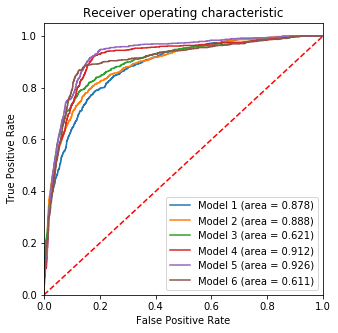

In [146]:
models = [M1, M2, M3, M1B, M2B, M3B]
plt.figure(figsize=(5,5))

for i in range(len(models)):
    if i in [0,1]:
        logit_roc_auc = roc_auc_score(y_test, models[i].predict(x_test))
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(x_test))
        plt.plot(fpr, tpr, label='Model %d (area = %0.3f)' % (i+1,logit_roc_auc))
        continue
    
    elif i == 2:
        logit_roc_auc = roc_auc_score(y_test, models[i].predict(x_test))
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(x_test)[:,1])
        plt.plot(fpr, tpr, label='Model %d (area = %0.3f)' % (i+1,logit_roc_auc))
        continue
        
    elif i in [3,4]:
        logit_roc_auc = roc_auc_score(y_test, models[i].predict(x_test[:,f]))
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(x_test[:,f]))
        plt.plot(fpr, tpr, label='Model %d (area = %0.3f)' % (i+1,logit_roc_auc))
        continue
        
    elif i == 5:
        logit_roc_auc = roc_auc_score(y_test, models[i].predict(x_test[:,f]))
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(x_test[:,f])[:,1])
        plt.plot(fpr, tpr, label='Model %d (area = %0.3f)' % (i+1,logit_roc_auc))
        continue
        
plt.plot([0, 1], [0, 1],'r--')    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Part 5 - Plot Model AUC with y_val

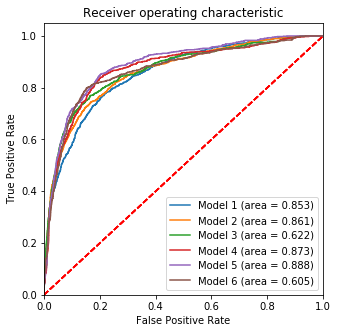

In [147]:
models = [M1, M2, M3, M1B, M2B, M3B]
plt.figure(figsize=(5,5))

for i in range(len(models)):
    if i in [0,1]:
        logit_roc_auc = roc_auc_score(y_val, models[i].predict(X_val))
        fpr, tpr, thresholds = roc_curve(y_val, models[i].predict_proba(X_val))
    
    elif i == 2:
        logit_roc_auc = roc_auc_score(y_val, models[i].predict(X_val))
        fpr, tpr, thresholds = roc_curve(y_val, models[i].predict_proba(X_val)[:,1])
        
    elif i in [3,4]:
        logit_roc_auc = roc_auc_score(y_val, models[i].predict(X_val[:,f]))
        fpr, tpr, thresholds = roc_curve(y_val, models[i].predict_proba(X_val[:,f]))
        
    elif i == 5:
        logit_roc_auc = roc_auc_score(y_val, models[i].predict(X_val[:,f]))
        fpr, tpr, thresholds = roc_curve(y_val, models[i].predict_proba(X_val[:,f])[:,1])
        
    plt.plot(fpr, tpr, label='Model %d (area = %0.3f)' % (i+1,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### Save models

In [150]:
import pickle
M1.save('Models/Model_1_NN_CE.h5')
M2.save('Models/Model_2_NN_FL.h5')
filename = 'Models/Model_3_LR.pickle'
pickle.dump(M3, open(filename, 'wb'))
M1B.save('Models/Model_1b_NN_CE_wo_Node2Vec.h5')
M2B.save('Models/Model_2b_NN_FL_wo_Node2Vec.h5')
filename = 'Models/Model_3b_LR_wo_Node2Vec.pickle'
pickle.dump(M3B, open(filename, 'wb'))

# Part 6 - Plot Model Performance

In [152]:
model_performances = pd.read_csv('Models/Model_Performances.csv')
model_performances

,FEATURE,M1,M2,M3,M1B,M2B,M3B
0,TP_test,617,446,215,683,530,199
1,TN_test,7941,8723,9007,7968,8617,8994
2,FP_test,229,400,631,163,316,647
3,FN_test,1178,396,112,1151,502,125
4,TP_val,613,439,227,661,529,197
5,TN_val,7771,8640,8959,7739,8496,8949
6,FP_val,268,442,654,220,352,684
7,FN_val,1304,435,116,1336,579,126


In [153]:
m1 = model_performances['M1'].values
m1b = model_performances['M1B'].values
m2 = model_performances['M2'].values
m2b = model_performances['M2B'].values
m3 = model_performances['M3'].values
m3b = model_performances['M3B'].values

Text(0.5,1,'Model Performance on Validation Set')

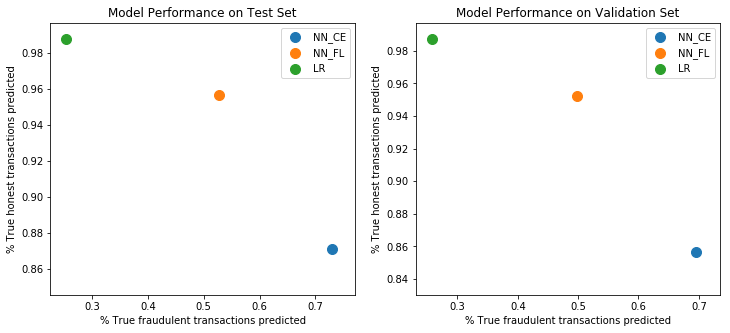

In [171]:
# Plot Performance in Test set
plt.figure(figsize=(12,5))

plt.subplot(121)
total_frauds = 846
total_non_frauds = 7941 + 1178
plt.scatter(m1[0]/total_frauds,m1[1]/total_non_frauds,label='NN_CE',s=100)
plt.scatter(m2[0]/total_frauds,m2[1]/total_non_frauds,label='NN_FL',s=100)
plt.scatter(m3[0]/total_frauds,m3[1]/total_non_frauds,label='LR',s=100)
plt.legend()
plt.xlabel('% True fraudulent transactions predicted')
plt.ylabel('% True honest transactions predicted')
plt.title('Model Performance on Test Set')

plt.subplot(122)
total_frauds = 613+268
total_non_frauds = 7771 + 1304
plt.scatter(m1[4]/total_frauds,m1[5]/total_non_frauds,label='NN_CE',s=100)
plt.scatter(m2[4]/total_frauds,m2[5]/total_non_frauds,label='NN_FL',s=100)
plt.scatter(m3[4]/total_frauds,m3[5]/total_non_frauds,label='LR',s=100)
plt.legend()
plt.xlabel('% True fraudulent transactions predicted')
plt.ylabel('% True honest transactions predicted')
plt.title('Model Performance on Validation Set')